In [1]:
import pandas as pd
import numpy as np
import datetime
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

# to be able to use .head(100) to see more rows of df
pd.set_option("display.max_rows", 100, "display.max_columns", None)
pd.set_option('use_inf_as_na', True)

In [2]:
# read the data
df = pd.read_csv('dataset_mood_smartphone.csv', index_col=0)

# get dates from timestamp
df['time']= pd.to_datetime(df['time'])
df['date'] = df['time'].dt.date

# Feature Engineering setup

In [3]:
# find week with most mood values per user and number of mood values of the next day
def define_dates(df, interval):
    data = df.copy()
    data['date'] = pd.to_datetime(data['date'])
    users = data['id'].unique()
    dates = []
    next_date_entries = []
    
    for user in users:
        attempt = 0
        weeks = data[(data['id'] == user) & (data['variable'] == 'mood')].groupby(['id', pd.Grouper(key='date', freq='W-MON')])['value'].sum().sort_values(ascending=False).index
        date = weeks[0]
        next_date_entry = data[(data['date'] == date[1] + pd.Timedelta(days=interval)) & (data['variable'] == 'mood') & (data['id'] == user)]['value'].count()
        penultimate_entry = data[(data['date'] == date[1] + pd.Timedelta(days=interval-1)) & (data['variable'] == 'mood') & (data['id'] == user)]['value'].count()
        
        while next_date_entry == 0 or penultimate_entry == 0:
            attempt += 1
            date = weeks[attempt]
            next_date_entry = data[(data['date'] == date[1] + pd.Timedelta(days=interval)) & (data['variable'] == 'mood') & (data['id'] == user)]['value'].count()
            penultimate_entry = data[(data['date'] == date[1] + pd.Timedelta(days=interval-1)) & (data['variable'] == 'mood') & (data['id'] == user)]['value'].count()

        
        dates.append(date)
        next_date_entries.append(next_date_entry)
    return dates, next_date_entries

dates, next_date_entries = define_dates(df, 7)

In [4]:
def define_weights(df, dates):
    data = df.copy()
    weight_per_user = []
    
    for tup in dates:
        user = tup[0]
        date = tup[1].date()
        weight = 1
        for i in range(7):
            day = date + pd.Timedelta(days=i) 
            weight *= 1.4
            weight_per_user.append({'id':user, 'time':pd.Timestamp(day) , 'date':day, 'variable':'weight', 'value': int(weight)})
        
    return weight_per_user

In [5]:
# add weight to df
weight_per_user = define_weights(df, dates)
df = df.append(pd.DataFrame(weight_per_user))

In [6]:
def sleep_calculation(df):
    data = df.copy()
    sleep_per_user = []
    
    # iterate over unique users
    for user in data['id'].unique():

        # gather user's data
        df_user = data[data['id'] == user]

        # iterate over unique dates
        for day in pd.to_datetime(df_user["time"]).map(pd.Timestamp.date).unique():
#             print(day)

            # define start and end of the night
            start_night = pd.Timestamp(day) - pd.Timedelta(3, 'h')
            end_night = pd.Timestamp(day) + pd.Timedelta(9, 'h')
            
            # get all the times of measurements during the night
            time_deltas = df_user[(df_user['time'] >= start_night) & (df_user['time'] < end_night)]['time'].values

            # calculate sleep as the largest interval between measurements, if more than one measurement
            if len(time_deltas) > 1:
                sleep = int(max(abs(x - y) for (x, y) in zip(time_deltas[1:], time_deltas[:-1])) / np.timedelta64(1, 'h'))

            # otherwise, set sleep to 12 (changeable)
            else:
                sleep = 12

            sleep_per_user.append({'id':user, 'time':pd.Timestamp(day), 'date':day, 'variable':'sleep', 'value': sleep})
            
    return sleep_per_user

In [7]:
# add sleep to df
sleep_per_user = sleep_calculation(df)
df = df.append(pd.DataFrame(sleep_per_user))

In [8]:
# turn 'variable' into separate columns, taking sum of values per day per user
df_sum = df.groupby(['id', 'date', 'variable'])['value'].sum().unstack()

# turn 'variable' into separate columns, taking mean of values per day per user
df_mean = df.groupby(['id', 'date', 'variable'])['value'].mean().unstack()

In [9]:
# combine mean of score values and sum of time values into one dataframe
df_combi = df_sum
df_combi['mood'] = df_mean['mood']
df_combi['circumplex.arousal'] = df_mean['circumplex.arousal']
df_combi['circumplex.valence'] = df_mean['circumplex.valence']
df_combi['activity'] = df_mean['activity']
df_combi['weight'] = df_combi['weight'].fillna(0).sort_values()
df_combi.columns.name = None

In [10]:
df_to_rol = df_combi.reset_index(level='id')
df_rolled = df_to_rol.groupby('id').rolling(7, min_periods=5).mean()
df_rolled['mean_mood'] = df_mean['mood']

In [11]:
df_rolled = df_rolled.dropna(axis = 0, how = 'all')
df_rolled = df_rolled.dropna(subset=['mood','screen'], how='all')
df_rolled = df_rolled.reset_index(level='id')
df_rolled = df_rolled.reset_index(level='date')

In [12]:
# determine whether date is a weekend day or not
def weekend(df):
    data = df.copy()
    weekend_bools = {}
    
    # iterate over unique dates
    for date in data['date'].unique():
        
        # check day of the week (5 and 6 are saturday and sunday)
        if date.weekday() > 4:
            weekend_bools[date] = 1
        else:
            weekend_bools[date] = 0
            
    return weekend_bools

In [13]:
# add weekend bools to df
weekend_bools = weekend(df_rolled)
df_rolled['weekend'] = df_rolled['date'].map(weekend_bools)

In [14]:
def geneva_emo_wheel(df):
    for index, row in df.iterrows():
        #neutral
        if 0 == row['circumplex.arousal'] and 0 == row['circumplex.valence']:
            df.loc[index, 'emo_wheel'] = 0
        
        #high arousal positive valance
        if 0 <= row['circumplex.arousal'] and 0 <= row['circumplex.valence']: 
            df.loc[index, 'emo_wheel'] = 1
         
        #low arousal positive valance    
        elif 0 >= row['circumplex.arousal'] and 0 <= row['circumplex.valence']: 
            df.loc[index, 'emo_wheel'] = 2
        
        #high arousal negative valance
        elif 0 <= row['circumplex.arousal'] and 0 >= row['circumplex.valence']: 
            df.loc[index, 'emo_wheel'] = 3
       
        #low arousal negative valance
        elif 0 >= row['circumplex.arousal'] and 0 >= row['circumplex.valence']: 
            df.loc[index, 'emo_wheel'] = 4
        else:
             df.loc[index, 'emo_wheel'] = 0
    return df

In [15]:
df_rolled['emo_wheel'] = 0
df_rolled = geneva_emo_wheel(df_rolled)


In [16]:
corr = df_rolled[2:].corr()
corr.style.background_gradient(cmap='coolwarm')

,activity,appCat.builtin,appCat.communication,appCat.entertainment,appCat.finance,appCat.game,appCat.office,appCat.other,appCat.social,appCat.travel,appCat.unknown,appCat.utilities,appCat.weather,call,circumplex.arousal,circumplex.valence,mood,screen,sleep,sms,weight,mean_mood,weekend,emo_wheel
activity,1.000000,0.040524,0.435504,0.058149,-0.219898,0.466315,0.006154,0.201185,-0.149844,-0.087810,0.160199,0.132420,0.026115,0.025430,-0.069708,0.232739,0.198343,0.371743,0.005675,-0.065630,0.075564,0.137487,0.012382,-0.061367
appCat.builtin,0.040524,1.000000,-0.032319,-0.051758,0.196806,-0.305843,-0.290658,-0.049628,0.202954,0.120545,0.029407,0.256912,0.169721,-0.021943,0.040623,0.000199,0.091549,0.238603,0.241560,-0.276339,0.097991,0.047635,-0.009138,-0.033360
appCat.communication,0.435504,-0.032319,1.000000,0.206977,0.231068,0.595374,0.082591,0.385133,-0.111167,-0.200690,0.039831,0.024911,-0.567751,-0.144634,-0.323538,0.103372,0.116117,0.725106,0.241851,0.115941,0.043162,0.124579,0.004154,0.213964
appCat.entertainment,0.058149,-0.051758,0.206977,1.000000,-0.153013,0.348524,-0.216439,0.275995,-0.065833,-0.093333,0.238207,-0.308064,-0.155262,-0.136555,-0.166603,0.238931,0.266917,0.308833,-0.062828,0.536272,0.011809,0.194050,-0.007384,0.058103
appCat.finance,-0.219898,0.196806,0.231068,-0.153013,1.000000,-0.401864,0.084508,0.283626,0.025441,0.318359,-0.192893,0.085793,0.860822,-0.104996,-0.154850,0.005407,-0.019139,0.119605,0.033308,nan,0.019357,0.052859,0.092757,0.271534
appCat.game,0.466315,-0.305843,0.595374,0.348524,-0.401864,1.000000,0.039755,0.462883,-0.278616,-0.108858,0.154147,-0.652133,-0.644401,0.287225,-0.176886,0.409039,0.057977,0.583799,-0.409072,0.142469,0.071364,0.139387,0.016110,-0.094754
appCat.office,0.006154,-0.290658,0.082591,-0.216439,0.084508,0.039755,1.000000,-0.172174,0.362560,-0.115890,-0.014376,-0.056129,-0.281091,-0.343608,-0.117772,-0.230389,0.194052,0.138461,0.283327,0.351425,0.406142,0.093767,-0.018664,0.335549
appCat.other,0.201185,-0.049628,0.385133,0.275995,0.283626,0.462883,-0.172174,1.000000,-0.127072,-0.147386,0.091606,-0.159266,-0.550957,-0.183078,-0.156158,0.263327,0.176495,0.256643,-0.063917,0.125893,-0.002043,0.161205,-0.026165,0.041254
appCat.social,-0.149844,0.202954,-0.111167,-0.065833,0.025441,-0.278616,0.362560,-0.127072,1.000000,-0.174233,0.413278,-0.050830,0.508209,0.010078,-0.103336,-0.203332,-0.051390,0.400146,0.207666,-0.018799,-0.090075,-0.071624,-0.003484,0.128851
appCat.travel,-0.087810,0.120545,-0.200690,-0.093333,0.318359,-0.108858,-0.115890,-0.147386,-0.174233,1.000000,-0.259749,-0.101940,-0.478765,-0.123628,0.381903,0.138715,0.023013,-0.330043,0.171564,-0.016885,0.019491,0.019055,0.042426,-0.230160


#### Atributes

In [17]:
attributes = ['id', 'date','mood','mean_mood','emo_wheel', 'appCat.weather', 'appCat.entertainment', 'activity', 'appCat.office']#

In [18]:
df_sub = df_rolled[attributes]

In [19]:
#drop empty mood and fil NaN with zero
df_sub = df_sub.dropna(subset=['mood'], how='all')
df_sub = df_sub.replace([np.inf, -np.inf],0)
df_sub = df_sub.fillna(0)

In [20]:
# Remove outliers by only keeping values within 3 mad from the median
for column in df_sub.columns.tolist()[2:]: 
    
    median = df_sub[column].median()
    mad = df_sub[column].mad()
    
    outliers = df_sub[(df_sub[column] >= median+(3*mad)) & (df_sub[column] <= median-(3*mad))][column]
    df_sub = df_sub.replace(to_replace=outliers, value=0)

In [21]:
# get days to predict per user
dates_to_predict = [(date[0], date[1].date() + pd.Timedelta(days=7)) for date in dates]
df_predict = pd.DataFrame()

# create dataframe for days to predict per user
for date in dates_to_predict:
    df_predict = df_predict.append(df_sub[(df_sub['id'] == date[0]) & (df_sub['date'] == date[1])])

df_sub = df_sub.append(df_predict.copy()).drop_duplicates(keep=False)

# one-hot encode user ids, normalize and fillna to get same shape as train df
df_predict = df_predict.drop(['date'],axis = 1)
df_predict =  pd.get_dummies(df_predict, prefix='id')
df_predict = df_predict.fillna(0)

# define x and y for prediction
y_predict = df_predict['mood']
X_predict = df_predict.drop('mood', axis=1)
X_predict = (X_predict-X_predict.min())/(X_predict.max()-X_predict.min())
X_predict = X_predict.fillna(0)

In [22]:

df_sub = df_sub.drop(['date'],axis = 1)
#df_sub =  pd.get_dummies(df_sub, prefix='id')

In [23]:
for i in df_sub.columns.tolist()[1:]: #>>>> aangepast
    if not i in ['mood','mean_mood']:
        df_sub[i]=(df_sub[i]-df_sub[i].min())/(df_sub[i].max()-df_sub[i].min())

## RNN Model

In [24]:
X_train_all =[]
X_test_all = []
X_val_all = []
y_train_all = []
y_test_all = []
y_val_all = []

X_test_user = []
y_test_user = []

for i in df.id.unique():
    dfid = df_sub[df_sub['id'] == i]
    mood_id = dfid[['mood','emo_wheel']].values.tolist()

    X = []
    y = []
    for j in range(21,len(mood_id)):
        X.append([val for val in mood_id[j-21:j]])
        y.append([mood_id[j][0]])
    
    len_1 = int(len(X) * 0.8)
    len_2 = int(len_1* 0.8)
    X_test_dfid = dfid.tail(len(X)-len_2)
    X_train_all.append(X[:len_2])
    X_val_all.append(X[len_2:len_1])
    X_test_all.append(X[len_1:])
    X_test_user.append({i:X[len_1:]})
    
    
    y_train_all.append(y[:len_2])
    y_val_all.append(y[len_2:len_1])
    y_test_all.append(y[len_1:])
    y_test_user.append({i:y[len_1:]})

In [25]:
def flatlist(list):
    flat_list = []
    for l in list:
        for item in l:
            flat_list.append(item)
    return flat_list

In [26]:
X_train_all = np.array(flatlist(X_train_all))
X_test_all = np.array(flatlist(X_test_all))
X_val_all = np.array(flatlist(X_val_all))
y_train_all = np.array(flatlist(y_train_all))
y_test_all = np.array(flatlist(y_test_all))
y_val_all = np.array(flatlist(y_val_all))

In [27]:
X_train_all.shape, X_test_all.shape, X_val_all.shape

((352, 21, 2), (128, 21, 2), (105, 21, 2))

In [28]:
y_train_all.shape, y_test_all.shape, y_val_all.shape

((352, 1), (128, 1), (105, 1))

In [29]:
regressor = Sequential()
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train_all.shape[1], X_train_all.shape[2])))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))
regressor.add(Dense(units = 1))
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
regressor.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 21, 50)            10600     
                                                                 
 dropout (Dropout)           (None, 21, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 30,851
Trainable params: 30,851
Non-trainable params: 0
_________________________________________________________________


In [30]:
regressor.fit(X_train_all, y_train_all, epochs = 75, batch_size = 16, validation_data=(X_val_all, y_val_all))

Epoch 1/75
22/22 [==============================] - 3s 48ms/step - loss: 18.8513 - val_loss: 1.7154
Epoch 2/75
22/22 [==============================] - 0s 14ms/step - loss: 0.9130 - val_loss: 0.4478
Epoch 3/75
22/22 [==============================] - 0s 16ms/step - loss: 0.6482 - val_loss: 0.2879
Epoch 4/75
22/22 [==============================] - 0s 18ms/step - loss: 0.5784 - val_loss: 0.2657
Epoch 5/75
22/22 [==============================] - 0s 17ms/step - loss: 0.5741 - val_loss: 0.2645
Epoch 6/75
22/22 [==============================] - 0s 17ms/step - loss: 0.5474 - val_loss: 0.2643
Epoch 7/75
22/22 [==============================] - 0s 19ms/step - loss: 0.5270 - val_loss: 0.2636
Epoch 8/75
22/22 [==============================] - 0s 17ms/step - loss: 0.5600 - val_loss: 0.2693
Epoch 9/75
22/22 [==============================] - 0s 17ms/step - loss: 0.5298 - val_loss: 0.2695
Epoch 10/75
22/22 [==============================] - 0s 17ms/step - loss: 0.6037 - val_loss: 0.2619
Epoch 11

In [31]:
predicted_test_y = regressor.predict(X_test_all)

In [32]:
RNN_mse = metrics.mean_absolute_error(predicted_test_y, y_test_all)
RNN_rmse = metrics.mean_squared_error(predicted_test_y, y_test_all, squared=False)
RNN_r2 = metrics.r2_score(predicted_test_y, y_test_all)
RNN_acc = '-'

print(f'MSE = {RNN_mse}, RMSE = {RNN_rmse}, R2 = {RNN_r2}, accuracy = {RNN_acc}')
RNN_scores = {'model': 'Stochastic Gradient Descent', 'MSE':RNN_mse, 'RMSE':RNN_rmse, 'R2':RNN_r2, 'accuracy':RNN_acc}

MSE = 0.1522812298839054, RMSE = 0.20400154901166062, R2 = 0.8045277770589603, accuracy = -


In [33]:
true = df_rolled['mean_mood'].loc[X_test_dfid.index[0]:].values.tolist()

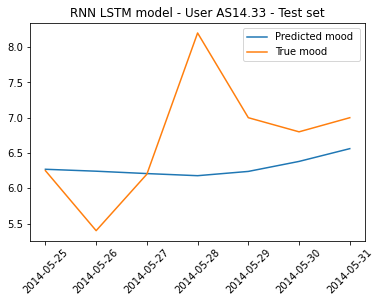

In [34]:
import matplotlib.pyplot as plt
z= df_rolled.loc[X_test_dfid.index[0]:].date

plt.plot(z,regressor.predict(X[len_2:]), label = "Predicted mood ")
plt.plot(z, true, label = "True mood")
user = df.id.unique().tolist()[-1]
plt.title(f'RNN LSTM model - User {user} - Test set')
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [35]:
# scores per user
mae = []
rmse = []
r2 = []
for i, item in enumerate(X_test_user):
    user = list(item.keys())[0]
    X_user = np.array(list(item.values())[0])
    Y_user = np.array(list(y_test_user[i].values())[0])

    mae.append(metrics.mean_absolute_error(regressor.predict(X_user), Y_user))
    rmse.append(metrics.mean_squared_error(regressor.predict(X_user), Y_user, squared=False)) 
    r2.append(metrics.r2_score(regressor.predict(X_user), Y_user))
    
scores_r = {'mae':mae, 'rmse':rmse, 'r2':r2}
scores_r

C:\Users\julia\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:682: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'mae': [0.21533956641242646,
  0.35828983972943035,
  0.09841167661878832,
  0.11227764629182335,
  0.06218145007178921,
  0.1858997199648904,
  0.16411096311750883,
  0.05000938688005707,
  0.4812470299857008,
  0.37397567279755045,
  0.2757393027411565,
  0.04826499923827162,
  0.13992487993189892,
  0.06537162235804968,
  0.0477294308798657,
  0.03565794990176272,
  0.2892981279463993,
  0.10473148903879156,
  0.06357255511813609,
  0.15178728255014573,
  0.03997181824275464,
  0.11011030055858544,
  0.1189636548360189,
  0.2626606123788012,
  0.021763099564445776,
  0.11873238245646107,
  0.17485791160946795],
 'rmse': [0.2163856947168798,
  0.4162840424537269,
  0.11603743016168068,
  0.126606366594043,
  0.09904696597420459,
  0.24585891706565066,
  0.20231635588533511,
  0.06344993041564306,
  0.48369687161472635,
  0.39600626659063454,
  0.30116561776303213,
  0.06091040873625996,
  0.16314314575063515,
  0.07871898872892652,
  0.04965582501390951,
  0.04309294594053306,
  0.3